In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

import pygame

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# brush properties
r = 20
s = 1

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)

    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask

    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] + 5.
    return state


def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)

    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask

    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] - 0.2
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), len(cdim_order))

    return cdim_order

def min_max(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

In [3]:
class Rule(nn.Module):
    def __init__(self, CHANNELS=8, FILTERS=1, HIDDEN=16, RADIUS=2):
        super().__init__()
        self.channels = CHANNELS
        self.filters = FILTERS
        self.hidden = HIDDEN

        Rk = RADIUS * 2 + 1
        # for forward_perception
        self.ident = torch.tensor([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]).cuda()
        self.sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]).cuda() / 8.0
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).cuda() / 16.0

        self.filters = [nn.Parameter(torch.randn(3, 3).cuda())
                        for i in range(2)]

        self.w1 = torch.nn.Conv2d(CHANNELS * 4, HIDDEN, 1)
        self.w1.bias.data.zero_()
        self.w2 = torch.nn.Conv2d(HIDDEN, CHANNELS, 1, bias=False)
        # self.w2.weight.data.zero_()
        ###########################################

class CA(nn.Module):
    def __init__(self, CHANNELS=8, FILTERS=1, HIDDEN=16, RADIUS=2):
        super().__init__()
        self.channels = CHANNELS
        self.filters = FILTERS
        self.hidden = HIDDEN
        self.radius = RADIUS


        self.rule = Rule(CHANNELS, FILTERS, HIDDEN, RADIUS)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-3)

    def initGrid(self, BS, RES):
        return torch.cuda.FloatTensor(2 * np.random.rand(BS, self.channels, RES, RES) - 1)

    def seed(self, RES, n):
        seed = torch.FloatTensor(np.zeros((n, self.channels, RES, RES)))
        # seed[:, 3:, RES // 2, RES // 2] = 1
        return seed

    def perchannel_conv(self, x, filters):
        '''filters: [filter_n, h, w]'''
        b, ch, h, w = x.shape
        y = x.reshape(b * ch, 1, h, w)
        y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
        y = torch.nn.functional.conv2d(y, filters[:, None])
        return y.reshape(b, -1, h, w)

    def perchannel_conv_g(self, x, filters):
        '''filters: [filter_n, h, w]'''
        b, ch, h, w = x.shape
        Rx = int((filters.shape[-2] - 1)/2)
        Ry = int((filters.shape[-1] - 1)/2)
        y = x.reshape(b * ch, 1, h, w)
        y = torch.nn.functional.pad(y, [Rx, Rx, Ry, Ry], 'circular')
        y = torch.nn.functional.conv2d(y, filters[:, None])
        return y.reshape(b, -1, h, w)

    def perception(self, x):
        # filters = torch.stack([self.rule.ident, self.rule.sobel_x, self.rule.sobel_x.T, self.rule.lap])
        filters = [self.rule.ident, self.rule.sobel_x, self.rule.sobel_x.T, self.rule.lap]
        # custom kernels required to be the same size as the hard-coded filters for now to work
        # totalistic_filters = [totalistic(f, dim2=True) for f in self.rule.filters]
        # filters = torch.stack(filters + totalistic_filters)
        return self.perchannel_conv(x, torch.stack(filters))

    def forward(self, x, dt=1, update_rate=0.5):
        b, ch, h, w = x.shape
        y = self.perception(x)

        y = torch.relu(self.rule.w1(y))
        y = self.rule.w2(y)

        update_mask = (torch.rand(b, 1, h, w) + update_rate).floor().cuda()
        y = dt * y * update_mask
        res = torch.clamp(x + y, 0, 1)
        return res

In [4]:
CHANNELS=8
FILTERS=1
HIDDEN=16

ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN).cuda()

# Training

Let's first try to train the model such that it has a large variance in space at the final time point in each individual channel. Right now, random models tend to converge to some saturation point.

In [5]:
def spatial_diversity(state):
    # computes the spatial variation in each channel and averages
    shape = state.shape
    loss = state.reshape(shape[0], shape[1], -1).std(dim=-1).mean()
    return -loss

def spatial_diversity_diversity(state):
    # computes the spatial variation in each channel and takes the variation of this
    shape = state.shape
    loss = state.reshape(shape[0], shape[1], -1).std(dim=-1).std()
    return -loss

def mean_rate(state_t, target=0.5):
    # returns the distance to the target rate for each pixel and channel and averages
    return (state_t.mean(dim=0) - target).abs().mean()

criterion = mean_rate

In [6]:
batch_size = 16
RES = 50

num_epochs = 250
min_T, max_T = 50, 95

loss_hist = []
for i in range(num_epochs):
    ca.optim.zero_grad()

    state = ca.initGrid(BS=batch_size, RES=RES)
    state_t = []
    for t in range(np.random.randint(min_T, max_T)):
        state = ca(state)
        state_t.append(state)
    state_t = torch.stack(state_t)

    loss = criterion(state_t)
    loss_hist.append(loss.item())
    loss.backward()
    ca.optim.step()

    if i % 50 == 0:
        print(f'Epoch: {i+1}/{num_epochs}, Loss: {loss_hist[-1]}')


Epoch: 1/250, Loss: 0.3770706355571747
Epoch: 51/250, Loss: 0.1664763242006302
Epoch: 101/250, Loss: 0.08242210745811462
Epoch: 151/250, Loss: 0.05222797766327858
Epoch: 201/250, Loss: 0.0408632755279541


# Visualize in PyGame

In [13]:
# pygame stuff
######################################
RES = 250
RESX, RESY = RES, RES
state = ca.initGrid(1, RES)

pygame.init()
size = RESX, RESY

win = pygame.display.set_mode((RESX, RESY))

screen = pygame.Surface(size)
UPSCALE = 3
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])


running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, state.shape[1])

clock = pygame.time.Clock()
font_h = pygame.font.SysFont("Noto Sans", 24)
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################


update_rate = 1.
ticker = 0.

export_imgs = False
imgs = []

with torch.no_grad():
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False

            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y

            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1] + 1)
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking

            if event.type == pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed
                state = ca.initGrid(BS=1, RES=RES)

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)

        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False

        nx = state[0, cdim_order[0], :, :].cpu().numpy()
        nx = min_max(state[0, cdim_order[0:3], :, :].cpu().numpy().transpose(1, 2, 0))
        nx = nx * 255.

        if time_ticking:
            state = ca.forward(state)
            ticker += 1

            if export_imgs:
                imgs.append(nx)

        pygame.surfarray.blit_array(screen, nx)
        frame = pygame.transform.scale(screen, (RESXup, RESYup))

        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))

        pygame.display.flip()
        clock.tick(120)

pygame.quit()


(array([65778., 24873., 24915., 29935., 49292., 61029., 83380., 36795.,
        26211., 97792.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

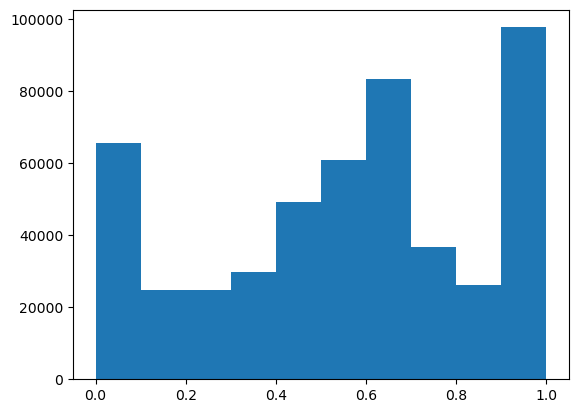

In [10]:
plt.hist(state.reshape(-1).cpu())